In [1]:
pip install pyogrio


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import pandas as pd
import pyogrio


In [72]:
shapefile_top =    gpd.read_file("/Users/phani/Desktop/Crop_yield_data copy/9x9 Grids/Top Field/2022_cc_driscoll_grid_9m_sorghum.shp") #4284 FID
shapefile_bottom = gpd.read_file("/Users/phani/Desktop/Crop_yield_data copy/9x9 Grids/Bottom Field /2022_cc_driscoll_grid_9m_cotton.shp") #4813 FID

In [52]:
with rasterio.open('/Users/phani/Desktop/Crop_yield_data copy/Satellite_Data/2020/20200331.tif') as src:
     # Get basic metadata about bands
    print(f"Number of bands: {src.count}")
    
    # Check band descriptions/names if available
    for i in range(1, src.count + 1):
        print(f"Band {i} description: {src.descriptions[i-1]}")
        

Number of bands: 4
Band 1 description: blue
Band 2 description: green
Band 3 description: red
Band 4 description: nir


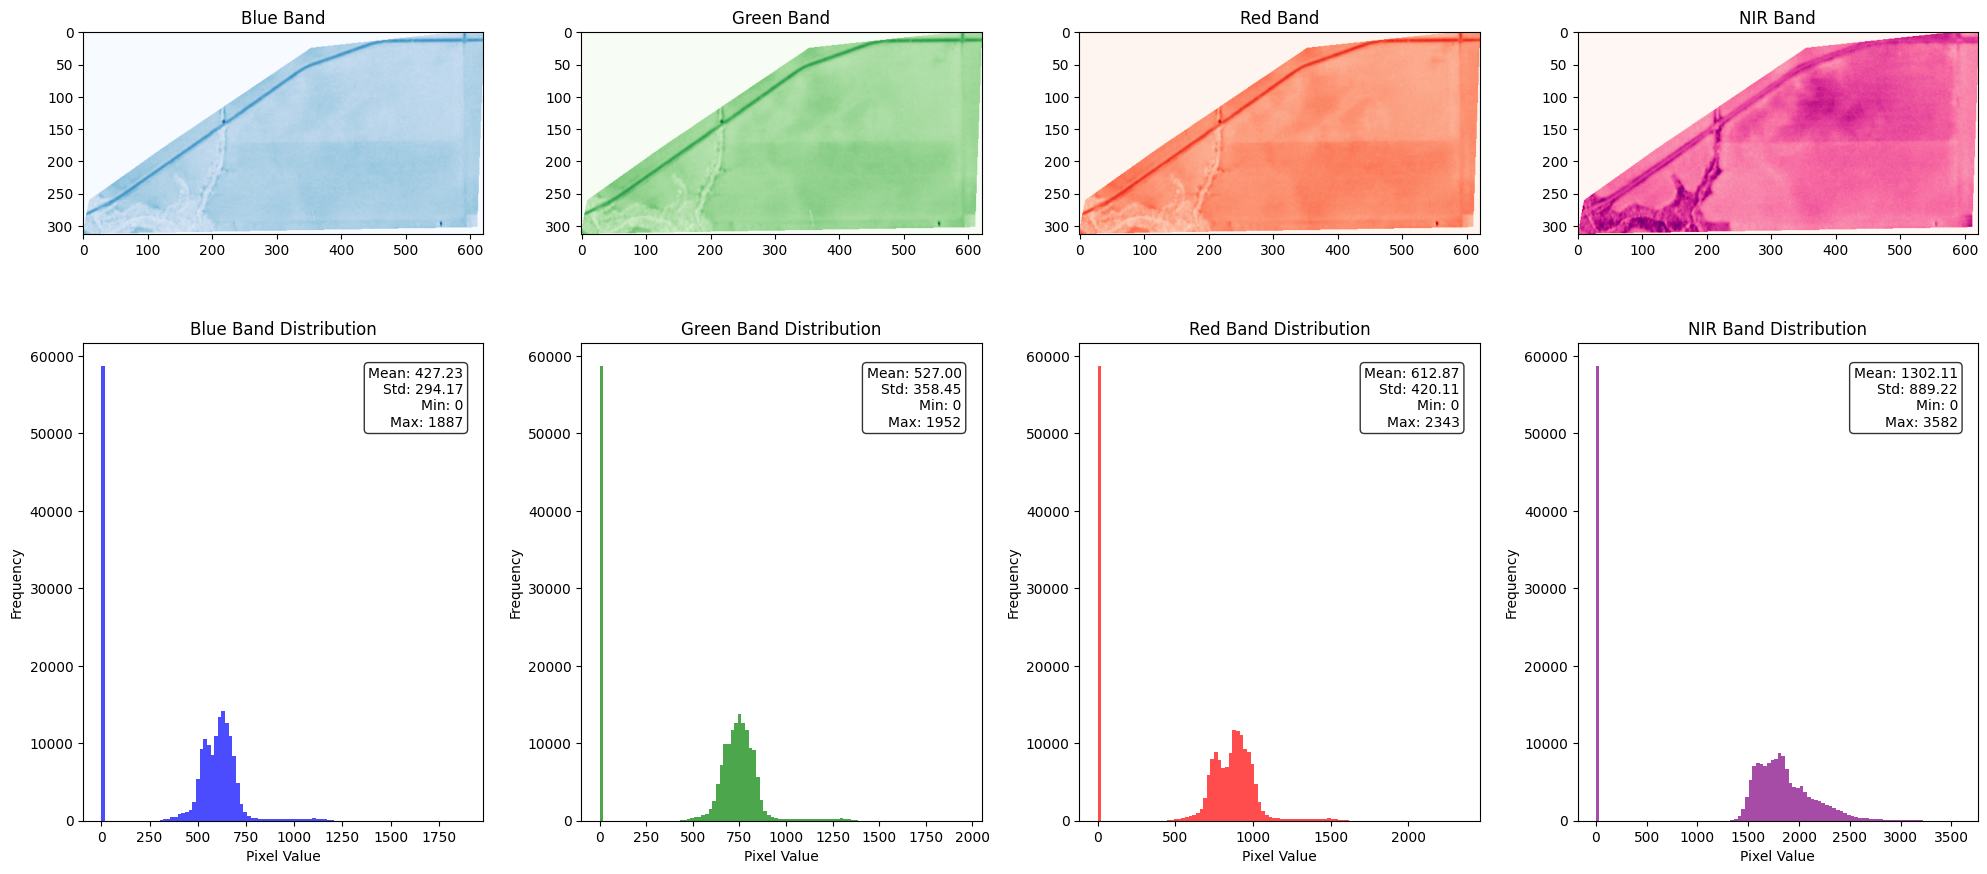

In [76]:
def plot_bands_and_distributions(tif_path):
    with rasterio.open(tif_path) as src:
        # Read all bands
        blue = src.read(1)
        green = src.read(2)
        red = src.read(3)
        nir = src.read(4)
        
        # Create figure with 2 rows and 4 columns
        fig, axs = plt.subplots(2, 4, figsize=(20, 10))
        
        # Plot bands
        show(blue, ax=axs[0,0], cmap='Blues')
        axs[0,0].set_title('Blue Band')
        
        show(green, ax=axs[0,1], cmap='Greens')
        axs[0,1].set_title('Green Band')
        
        show(red, ax=axs[0,2], cmap='Reds')
        axs[0,2].set_title('Red Band')
        
        show(nir, ax=axs[0,3], cmap='RdPu')
        axs[0,3].set_title('NIR Band')
        
        # Plot distributions
        axs[1,0].hist(blue.ravel(), bins=100, color='blue', alpha=0.7)
        axs[1,0].set_title('Blue Band Distribution')
        axs[1,0].set_xlabel('Pixel Value')
        axs[1,0].set_ylabel('Frequency')
        
        axs[1,1].hist(green.ravel(), bins=100, color='green', alpha=0.7)
        axs[1,1].set_title('Green Band Distribution')
        axs[1,1].set_xlabel('Pixel Value')
        axs[1,1].set_ylabel('Frequency')
        
        axs[1,2].hist(red.ravel(), bins=100, color='red', alpha=0.7)
        axs[1,2].set_title('Red Band Distribution')
        axs[1,2].set_xlabel('Pixel Value')
        axs[1,2].set_ylabel('Frequency')
        
        axs[1,3].hist(nir.ravel(), bins=100, color='purple', alpha=0.7)
        axs[1,3].set_title('NIR Band Distribution')
        axs[1,3].set_xlabel('Pixel Value')
        axs[1,3].set_ylabel('Frequency')
        
        # Add basic statistics to distribution plots
        for band, ax, name in zip([blue, green, red, nir], 
                                axs[1], 
                                ['Blue', 'Green', 'Red', 'NIR']):
            mean = np.mean(band)
            std = np.std(band)
            min_val = np.min(band)
            max_val = np.max(band)
            
            stats_text = f'Mean: {mean:.2f}\nStd: {std:.2f}\nMin: {min_val}\nMax: {max_val}'
            ax.text(0.95, 0.95, stats_text,
                   transform=ax.transAxes,
                   verticalalignment='top',
                   horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

# Call the function with your image path
tif_path = '/Users/phani/Desktop/Crop_yield_data copy/Satellite_Data/2020/20200331.tif'
plot_bands_and_distributions(tif_path)

In [50]:
with rasterio.open('/Users/phani/Desktop/Crop_yield_data copy/Satellite_Data/2020/20200331.tif') as src:
    print(src.descriptions)

('blue', 'green', 'red', 'nir')


In [54]:
pip install rasterstats

  Obtaining dependency information for rasterstats from https://files.pythonhosted.org/packages/5e/0b/bd73621d2a5f87da97158c5c77a4bf31e27d60cf6bcc6ddea532043cc21d/rasterstats-0.20.0-py3-none-any.whl.metadata
  Obtaining dependency information for simplejson from https://files.pythonhosted.org/packages/a9/e9/8cec3d3efcf284f6f929ba1ad0266cb77e7810ee7dc56046fbdd22b15fbd/simplejson-3.19.3-cp38-cp38-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 724.9 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [99]:
def select_shapefile(tif_path, top_shp_path, bottom_shp_path):
    """
    Select shapefile based on year (first 4 digits) being even/odd
    """
    try:
        # Get filename from path and extract first 4 characters (year)
        filename = os.path.basename(tif_path)
        year = int(filename[:4])
        
        # Select shapefile based on year being even/odd
        selected_shp_path = bottom_shp_path if year % 2 == 0 else top_shp_path
        print(f"Processing image: {filename}")
        print(f"Year: {year}")
        print(f"Selected shapefile: {selected_shp_path}")
        
        return gpd.read_file(selected_shp_path)
        
    except Exception as e:
        print(f"Error selecting shapefile: {e}")
        return None


def calculate_indices(raster_path, shapefile):
    """
    Calculate NDVI and GCI for the masked image with proper handling of invalid values
    """
    with rasterio.open(raster_path) as src:
        # Read bands (BGRNIR order)
        blue = src.read(1)
        green = src.read(2)
        red = src.read(3)
        nir = src.read(4)
        transform = src.transform
        
        # Create masks for each FID
        ndvi_values = {}
        gci_values = {}
        
        for idx, row in shapefile.iterrows():
            geometry = [row['geometry']]
            
            try:
                # Mask the image for current geometry
                masked_nir, _ = mask(src, geometry, crop=True, indexes=4)
                masked_red, _ = mask(src, geometry, crop=True, indexes=3)
                masked_green, _ = mask(src, geometry, crop=True, indexes=2)
                
                # Convert to float32 for better numerical precision
                masked_nir = masked_nir.astype(np.float32)
                masked_red = masked_red.astype(np.float32)
                masked_green = masked_green.astype(np.float32)
                
                # Create masks for valid pixels
                valid_ndvi_mask = (masked_nir + masked_red) != 0
                valid_gci_mask = masked_green != 0
                
                # Calculate NDVI with proper masking
                ndvi = np.full_like(masked_nir, np.nan)
                np.divide(
                    masked_nir - masked_red,
                    masked_nir + masked_red,
                    out=ndvi,
                    where=valid_ndvi_mask
                )
                
                # Calculate GCI with proper masking
                gci = np.full_like(masked_nir, np.nan)
                np.divide(
                    masked_nir,
                    masked_green,
                    out=gci,
                    where=valid_gci_mask
                )
                gci = np.where(valid_gci_mask, gci - 1, np.nan)
                
                
                # Calculate mean values, ignoring NaN
                ndvi_mean = np.nanmean(ndvi)
                gci_mean = np.nanmean(gci)
                
                # Store only if we have valid calculations
                if not np.isnan(ndvi_mean):
                    ndvi_values[row['FID']] = ndvi_mean
                if not np.isnan(gci_mean):
                    gci_values[row['FID']] = gci_mean
                    
            except Exception as e:
                print(f"Error processing FID {row['FID']}: {e}")
                ndvi_values[row['FID']] = np.nan
                gci_values[row['FID']] = np.nan
    
    # Print processing summary
    print(f"Processed {len(shapefile)} grids:")
    print(f"Valid NDVI values: {sum(~np.isnan(list(ndvi_values.values())))}")
    print(f"Valid GCI values: {sum(~np.isnan(list(gci_values.values())))}")
    
    return ndvi_values, gci_values

def create_output_dataframe(ndvi_values, gci_values):
    """
    Create DataFrame with calculated indices
    """
    df = pd.DataFrame({
        'FID': list(ndvi_values.keys()),
        'NDVI': list(ndvi_values.values()),
        'GCI': list(gci_values.values())
    })
    return df

def main(tif_path, top_shp_path, bottom_shp_path, output_csv):
    """
    Main function to process the image and calculate indices
    """
    try:
        # Select and load appropriate shapefile
        shapefile = select_shapefile(tif_path, top_shp_path, bottom_shp_path)
        if shapefile is None:
            raise ValueError("Could not select appropriate shapefile")
        
        # Calculate indices
        print("Calculating vegetation indices...")
        ndvi_values, gci_values = calculate_indices(tif_path, shapefile)
        
        # Create and save output
        print("Creating output DataFrame...")
        result_df = create_output_dataframe(ndvi_values, gci_values)
        result_df.to_csv(output_csv, index=False)
        print(f"Results saved to {output_csv}")
        
        # Print summary statistics
        print("\nSummary Statistics:")
        print("\nNDVI Statistics:")
        print(result_df['NDVI'].describe())
        print("\nGCI Statistics:")
        print(result_df['GCI'].describe())
        
        return result_df
        
    except Exception as e:
        print(f"Error in processing: {e}")
        return None

# Execute the script
if __name__ == "__main__":
    tif_path = "/Users/phani/Desktop/Crop_yield_data copy/Satellite_Data/2020/20200610.tif"
    top_shp_path = "/Users/phani/Desktop/Crop_yield_data copy/9x9 Grids/Top Field/2022_cc_driscoll_grid_9m_sorghum.shp"
    bottom_shp_path = "/Users/phani/Desktop/Crop_yield_data copy/9x9 Grids/Bottom Field /2022_cc_driscoll_grid_9m_cotton.shp"
    output_csv = "grid_indices.csv"
    
    result = main(tif_path, top_shp_path, bottom_shp_path, output_csv)

Processing image: 20200610.tif
Year: 2020
Selected shapefile: /Users/phani/Desktop/Crop_yield_data copy/9x9 Grids/Bottom Field /2022_cc_driscoll_grid_9m_cotton.shp
Calculating vegetation indices...
Processed 4813 grids:
Valid NDVI values: 4813
Valid GCI values: 4813
Creating output DataFrame...
Results saved to grid_indices.csv

Summary Statistics:

NDVI Statistics:
count    4813.000000
mean        0.733650
std         0.018323
min         0.502100
25%         0.725274
50%         0.732537
75%         0.742507
max         0.780884
Name: NDVI, dtype: float64

GCI Statistics:
count    4813.000000
mean        3.664852
std         0.272849
min         1.916384
25%         3.513084
50%         3.610711
75%         3.728326
max         4.604494
Name: GCI, dtype: float64


Plot saved to vegetation_indices_map.png


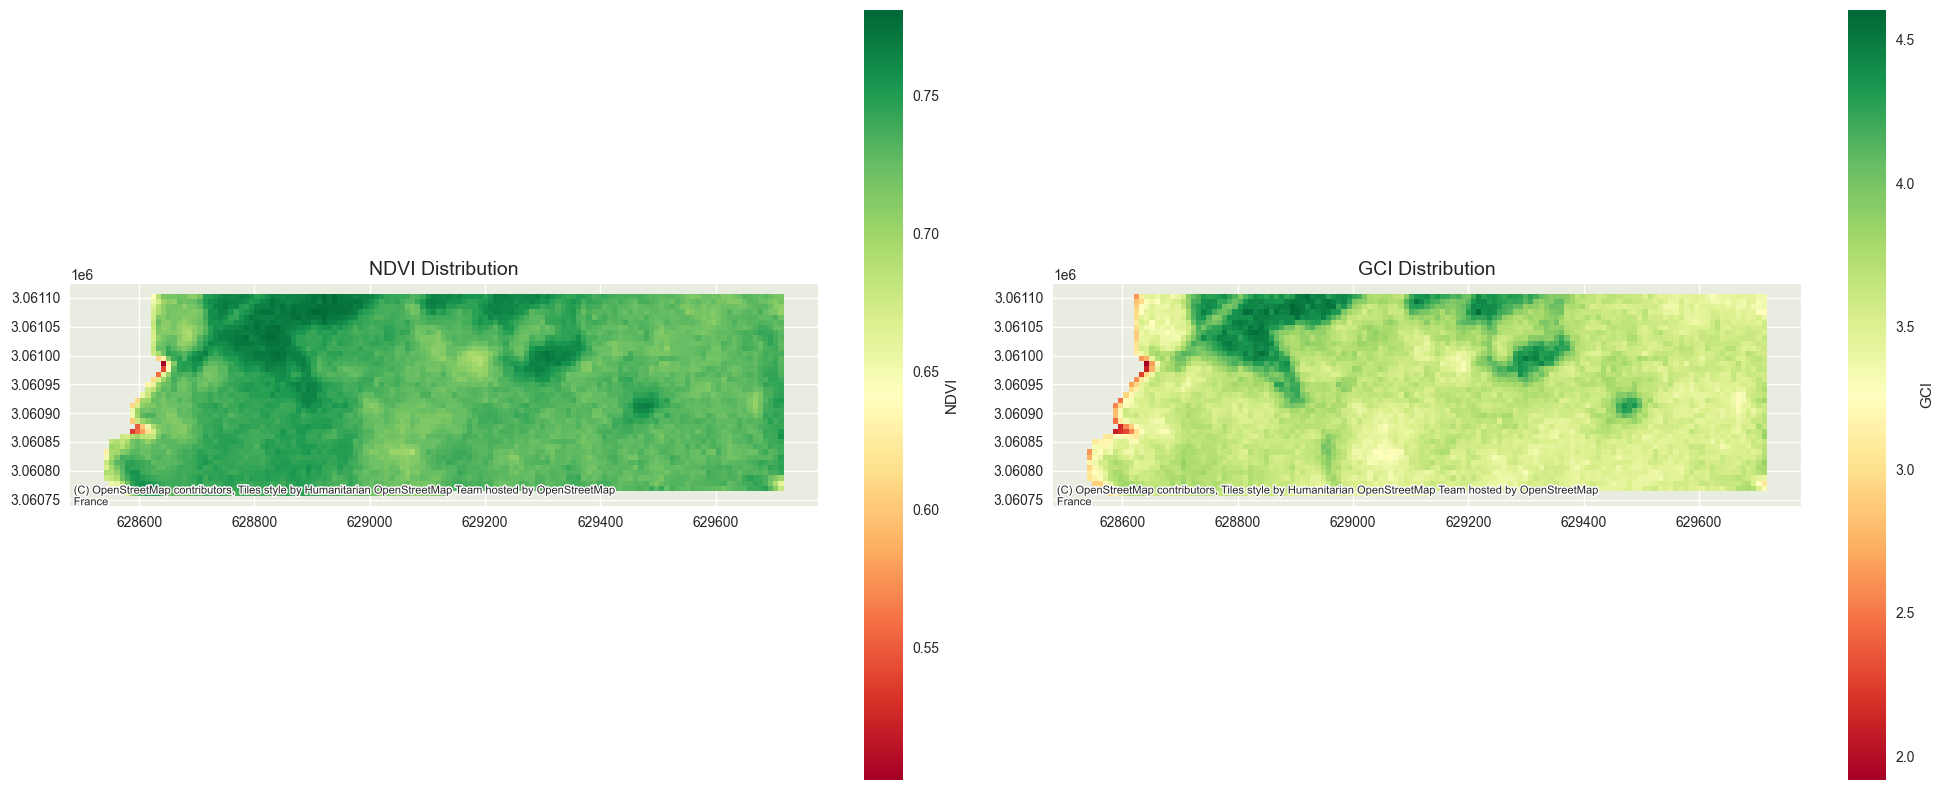

Statistical plots saved to vegetation_indices_map_stats.png


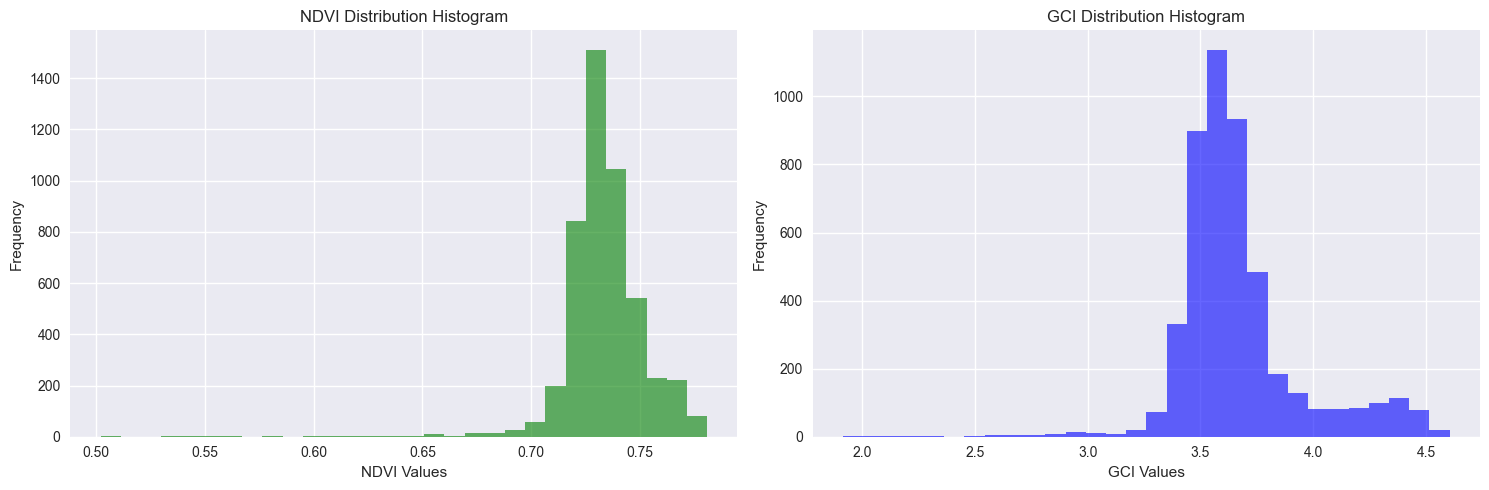


Summary Statistics:

NDVI Statistics:
count    4813.000000
mean        0.733650
std         0.018323
min         0.502100
25%         0.725274
50%         0.732537
75%         0.742507
max         0.780884
Name: NDVI, dtype: float64

GCI Statistics:
count    4813.000000
mean        3.664852
std         0.272849
min         1.916384
25%         3.513084
50%         3.610711
75%         3.728326
max         4.604494
Name: GCI, dtype: float64


In [98]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

def plot_indices_on_shapefile(shapefile_path, csv_path, output_path=None):
    """
    Plot NDVI and GCI values on the shapefile
    """
    # Read the data
    gdf = gpd.read_file(shapefile_path)
    indices_df = pd.read_csv(csv_path)
    
    # Merge the indices with shapefile
    gdf = gdf.merge(indices_df, on='FID')
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot NDVI
    gdf.plot(column='NDVI', 
            ax=ax1,
            legend=True,
            legend_kwds={'label': 'NDVI',
                        'orientation': 'vertical'},
            cmap='RdYlGn',  # Red-Yellow-Green colormap
            missing_kwds={'color': 'lightgrey'})
    
    ax1.set_title('NDVI Distribution', fontsize=14)
    ax1.axis('on')
    ax1.grid(True)
    
    # Plot GCI
    gdf.plot(column='GCI',
            ax=ax2,
            legend=True,
            legend_kwds={'label': 'GCI',
                        'orientation': 'vertical'},
            cmap='RdYlGn',
            missing_kwds={'color': 'lightgrey'})
    
    ax2.set_title('GCI Distribution', fontsize=14)
    ax2.axis('on')
    ax2.grid(True)
    
    # Add basemap if the CRS is in Web Mercator
    try:
        gdf_web_mercator = gdf.to_crs(epsg=3857)
        ctx.add_basemap(ax1, crs=gdf_web_mercator.crs)
        ctx.add_basemap(ax2, crs=gdf_web_mercator.crs)
    except:
        print("Could not add basemap. Check if projection is in Web Mercator.")
    
    plt.tight_layout()
    
    # Save plot if output path is provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_path}")
    
    plt.show()
    
    # Create additional statistical plots
    fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram of NDVI values
    gdf['NDVI'].hist(ax=ax3, bins=30, color='green', alpha=0.6)
    ax3.set_title('NDVI Distribution Histogram')
    ax3.set_xlabel('NDVI Values')
    ax3.set_ylabel('Frequency')
    
    # Histogram of GCI values
    gdf['GCI'].hist(ax=ax4, bins=30, color='blue', alpha=0.6)
    ax4.set_title('GCI Distribution Histogram')
    ax4.set_xlabel('GCI Values')
    ax4.set_ylabel('Frequency')
    
    plt.tight_layout()
    
    # Save statistical plots if output path is provided
    if output_path:
        stats_output = output_path.replace('.png', '_stats.png')
        plt.savefig(stats_output, dpi=300, bbox_inches='tight')
        print(f"Statistical plots saved to {stats_output}")
    
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print("\nNDVI Statistics:")
    print(gdf['NDVI'].describe())
    print("\nGCI Statistics:")
    print(gdf['GCI'].describe())
    
    return gdf

# Example usage
if __name__ == "__main__":
    shapefile_path = "/Users/phani/Desktop/Crop_yield_data copy/9x9 Grids/Bottom Field /2022_cc_driscoll_grid_9m_cotton.shp"  # or sorghum shapefile
    csv_path = "grid_indices.csv"
    output_path = "vegetation_indices_map.png"
    
    gdf = plot_indices_on_shapefile(shapefile_path, csv_path, output_path)

In [95]:
pip install seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Processing year: 2019
Saved time series plot to: /Users/phani/Desktop/Crop_yield_data copy/Indices/plots/indices_2019.png


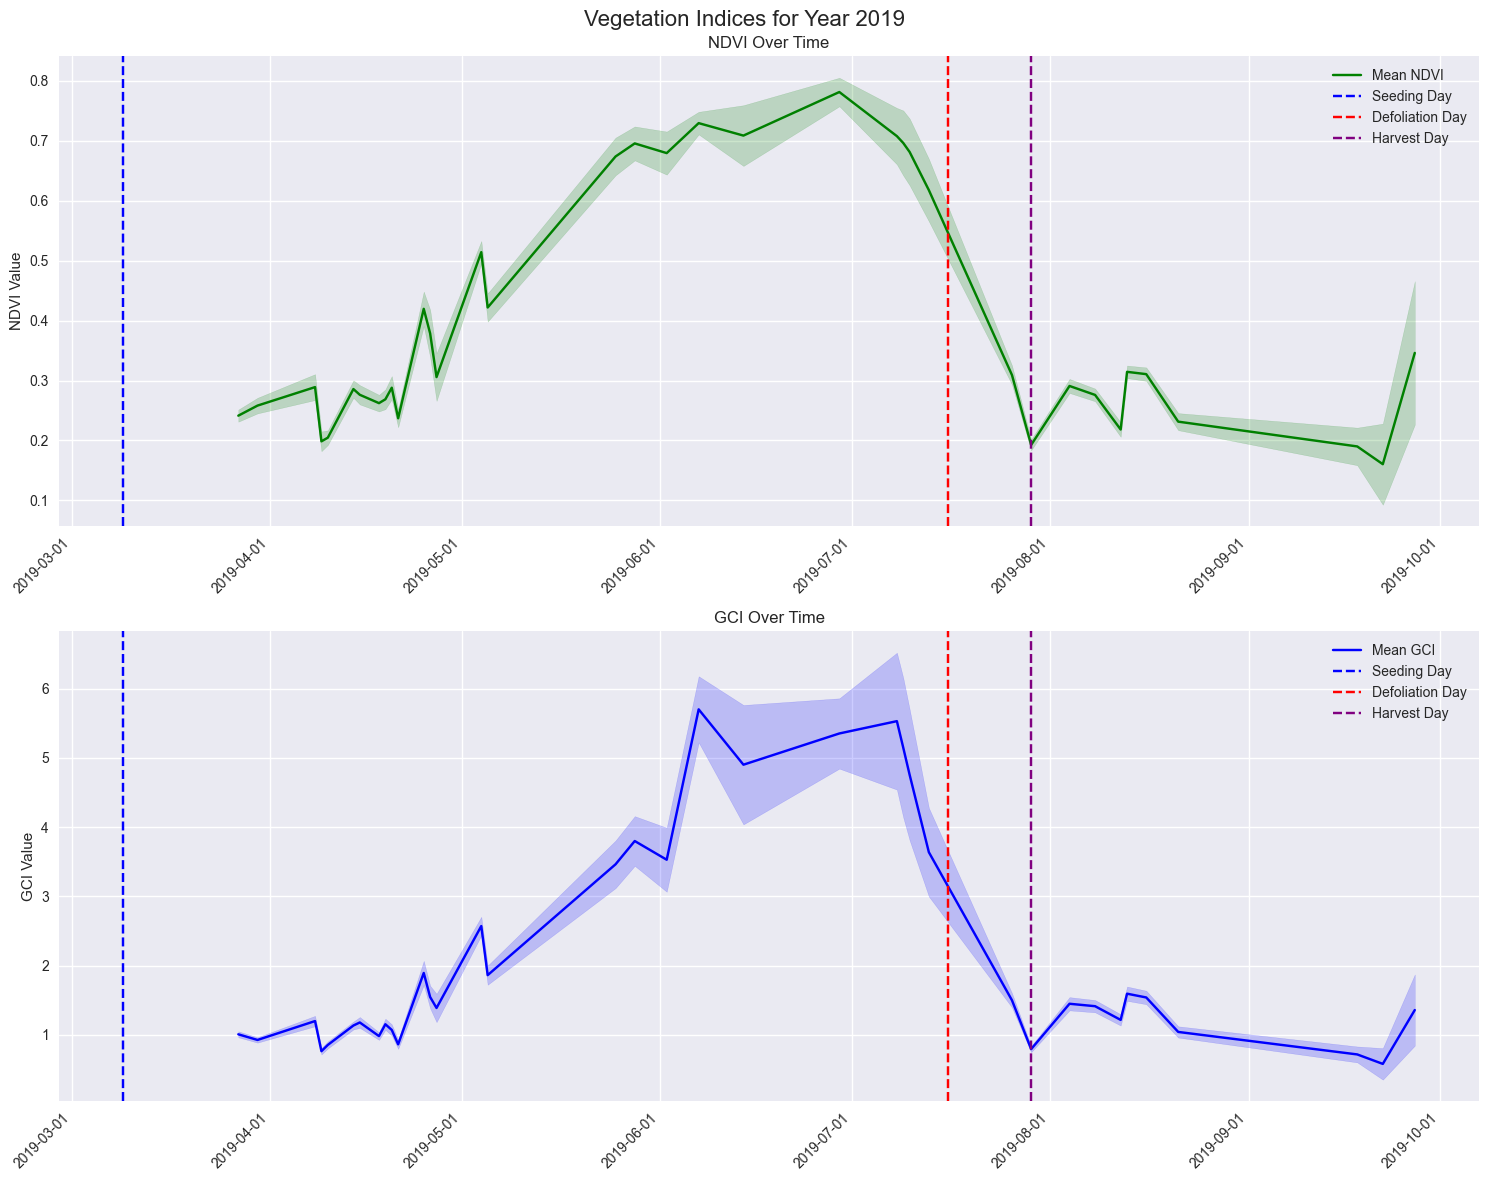

Saved boxplot to: /Users/phani/Desktop/Crop_yield_data copy/Indices/plots/indices_boxplot_2019.png


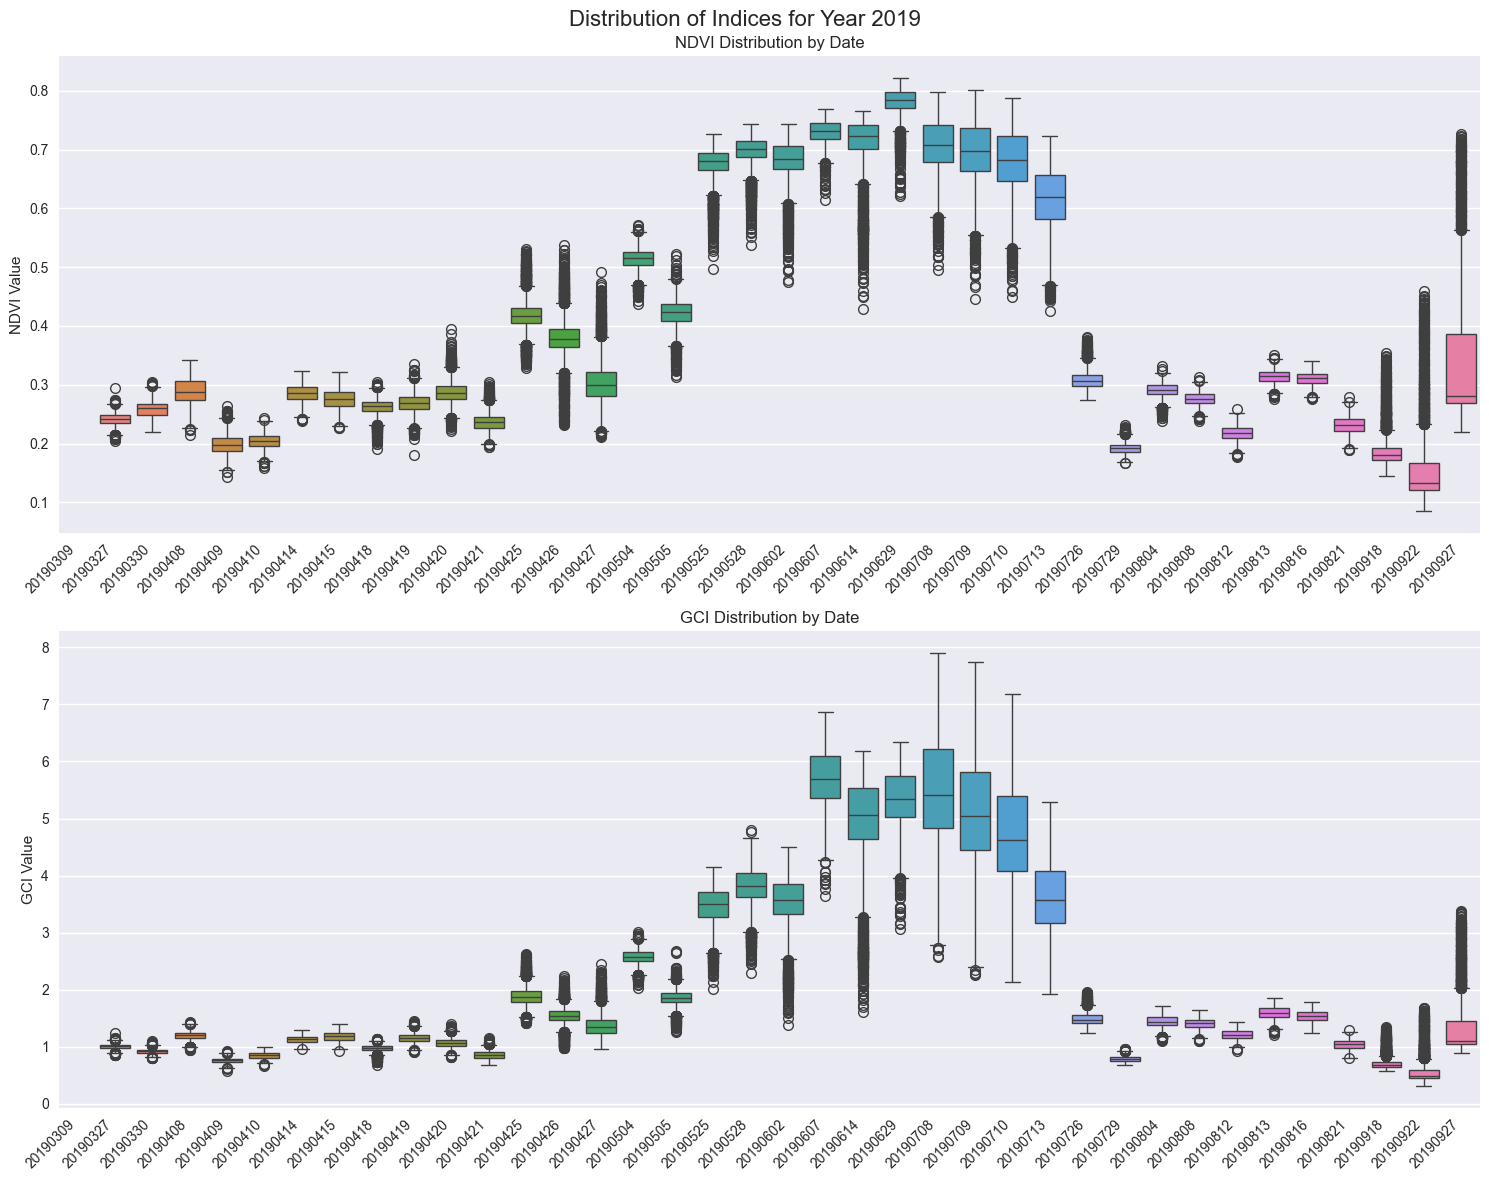

Processing year: 2020
Saved time series plot to: /Users/phani/Desktop/Crop_yield_data copy/Indices/plots/indices_2020.png


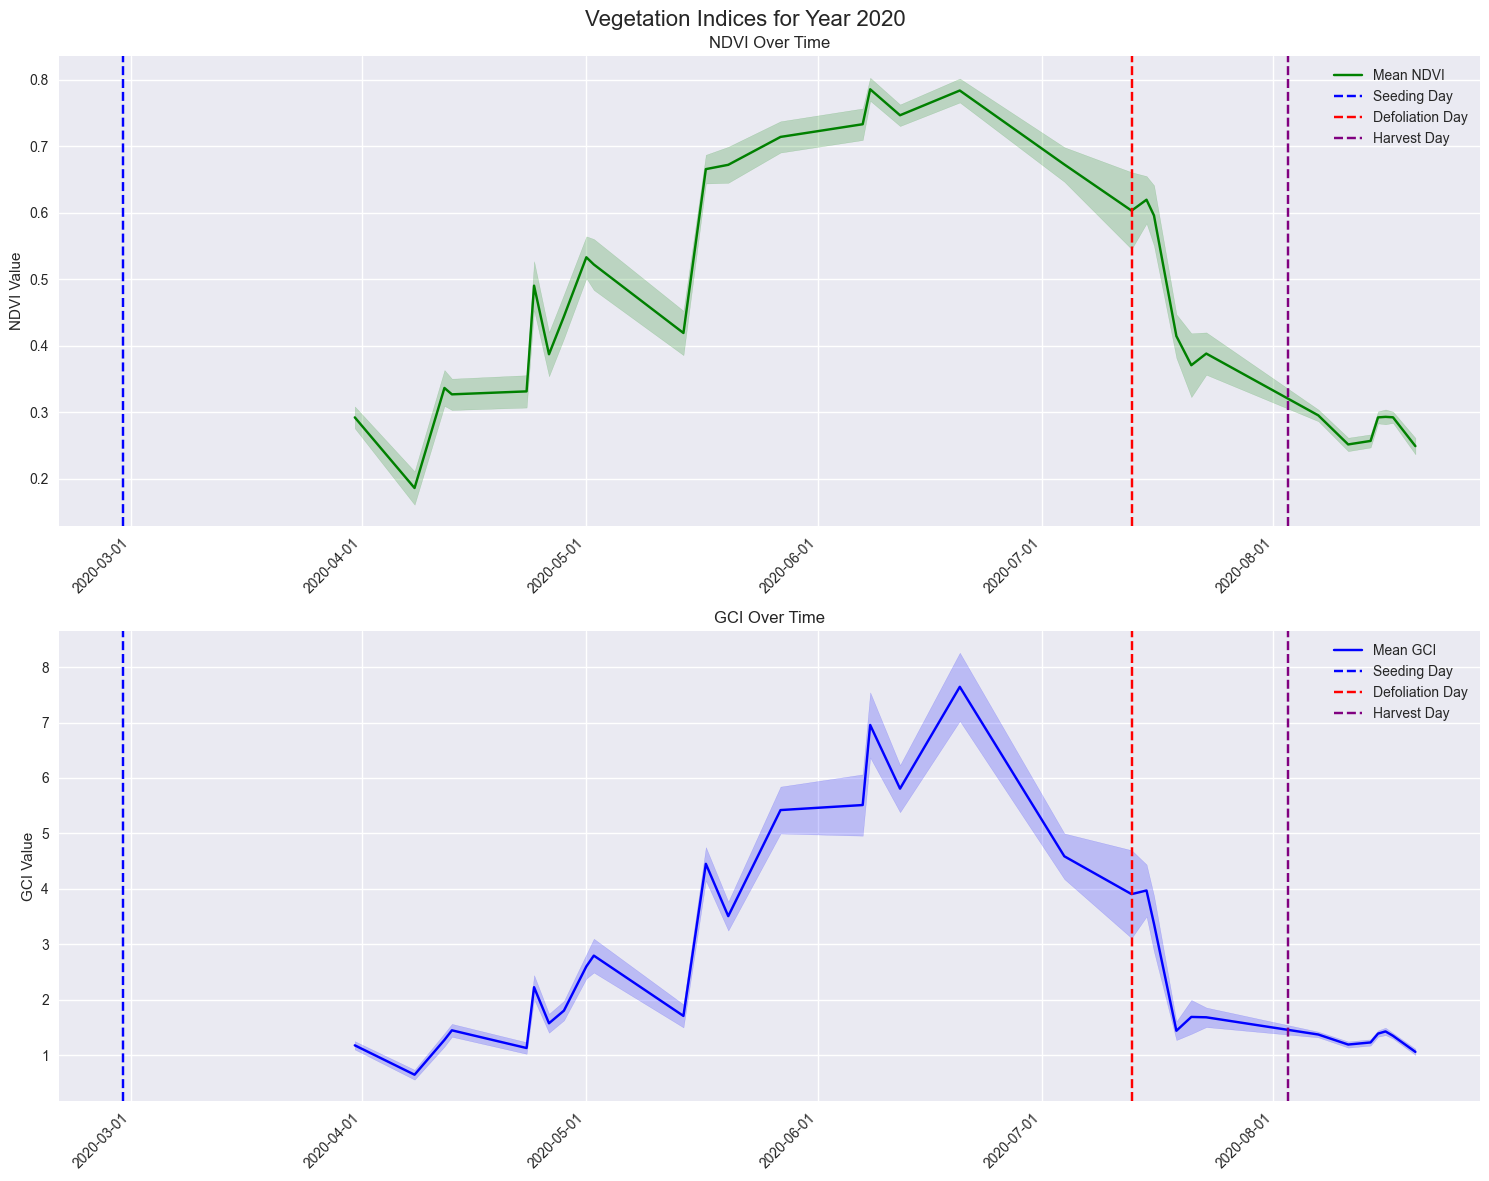

Saved boxplot to: /Users/phani/Desktop/Crop_yield_data copy/Indices/plots/indices_boxplot_2020.png


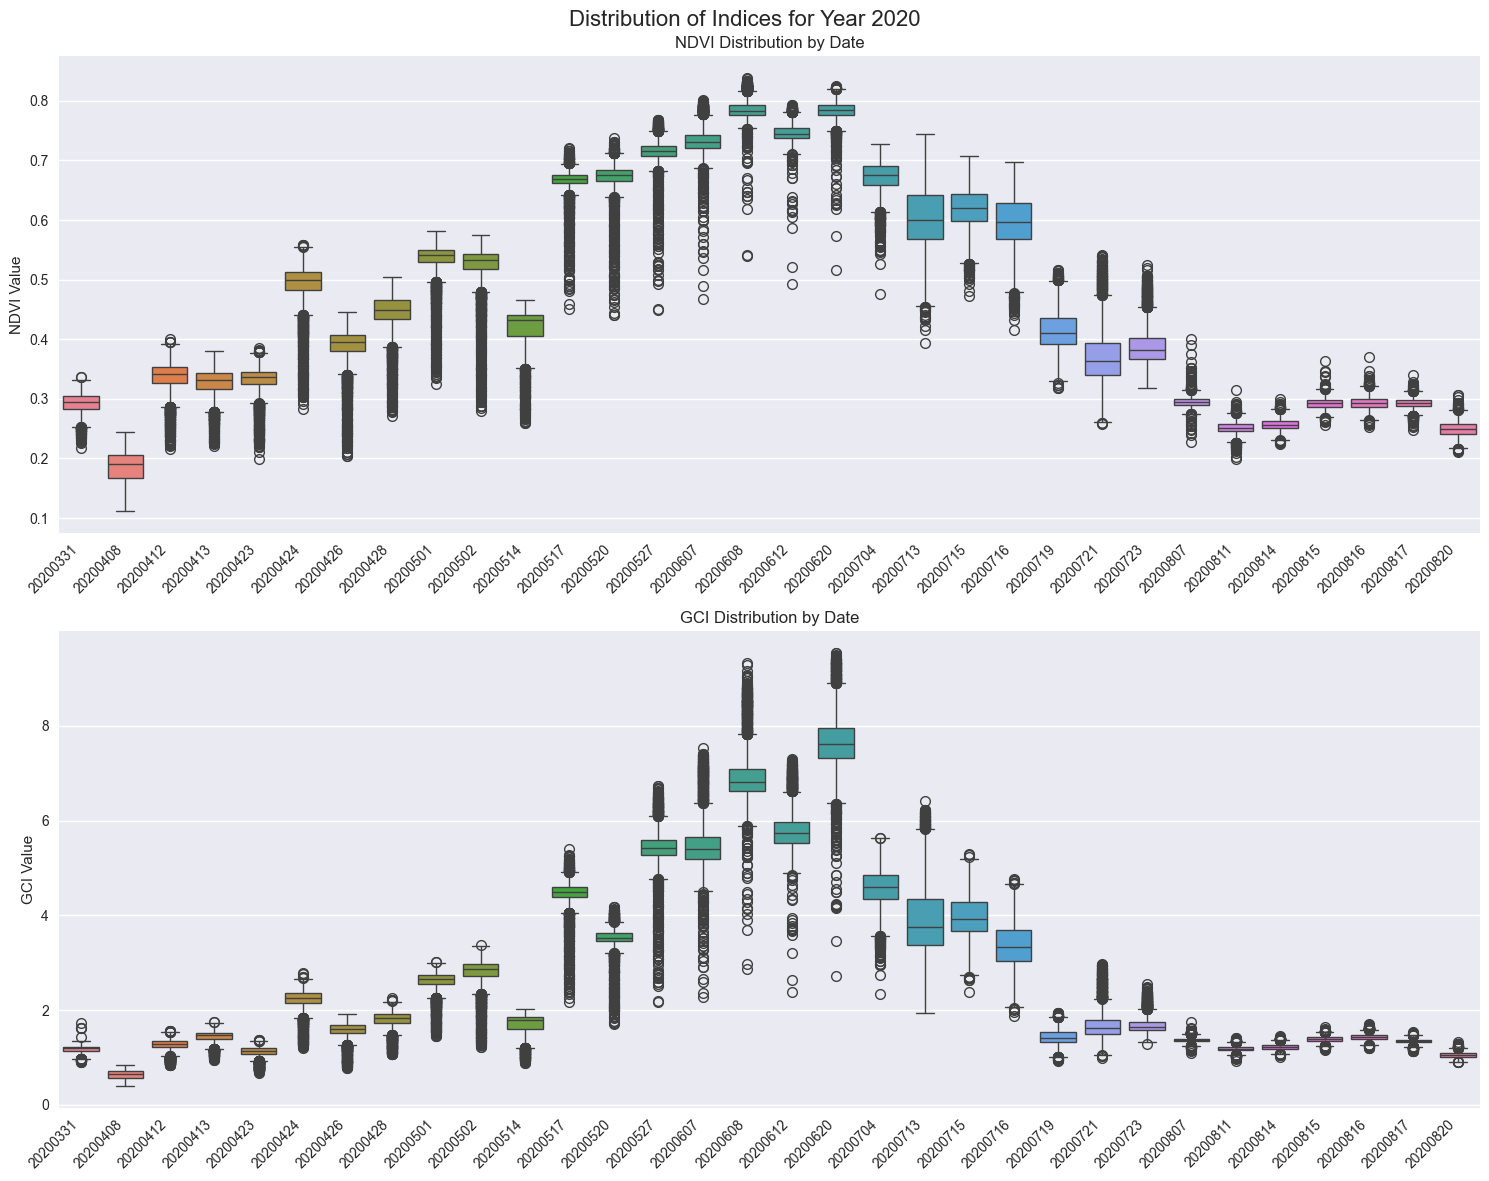

Processing year: 2021
Saved time series plot to: /Users/phani/Desktop/Crop_yield_data copy/Indices/plots/indices_2021.png


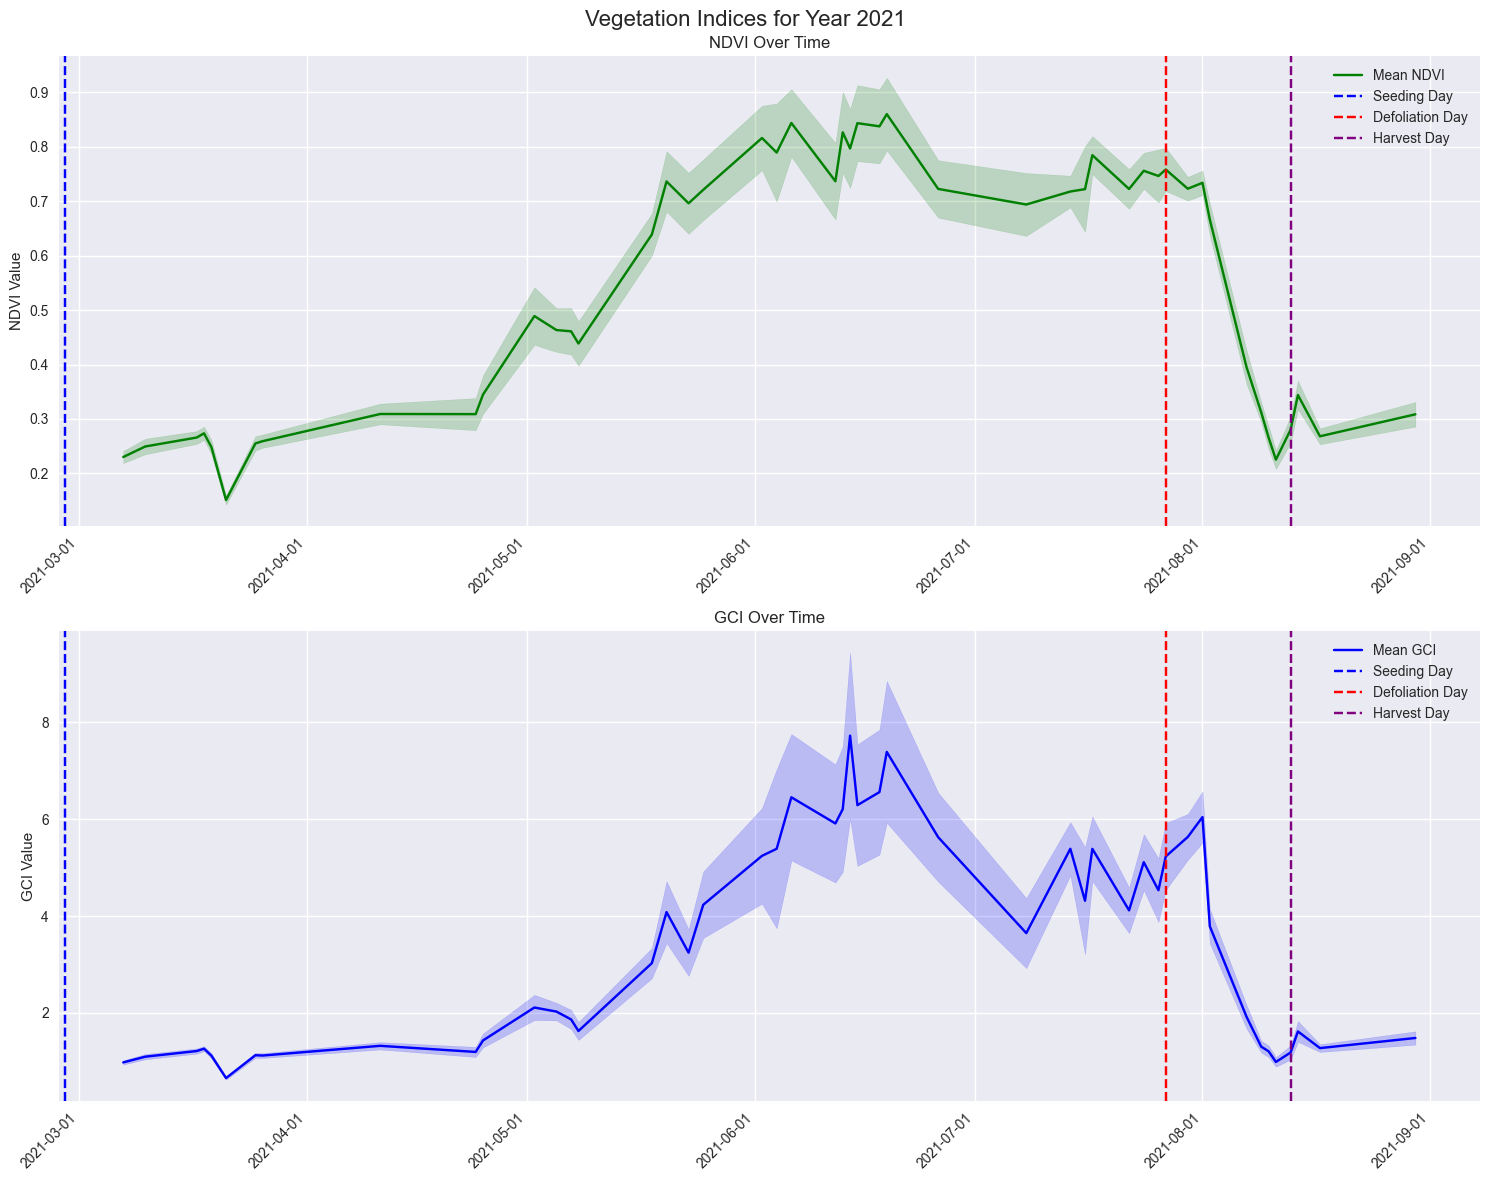

Saved boxplot to: /Users/phani/Desktop/Crop_yield_data copy/Indices/plots/indices_boxplot_2021.png


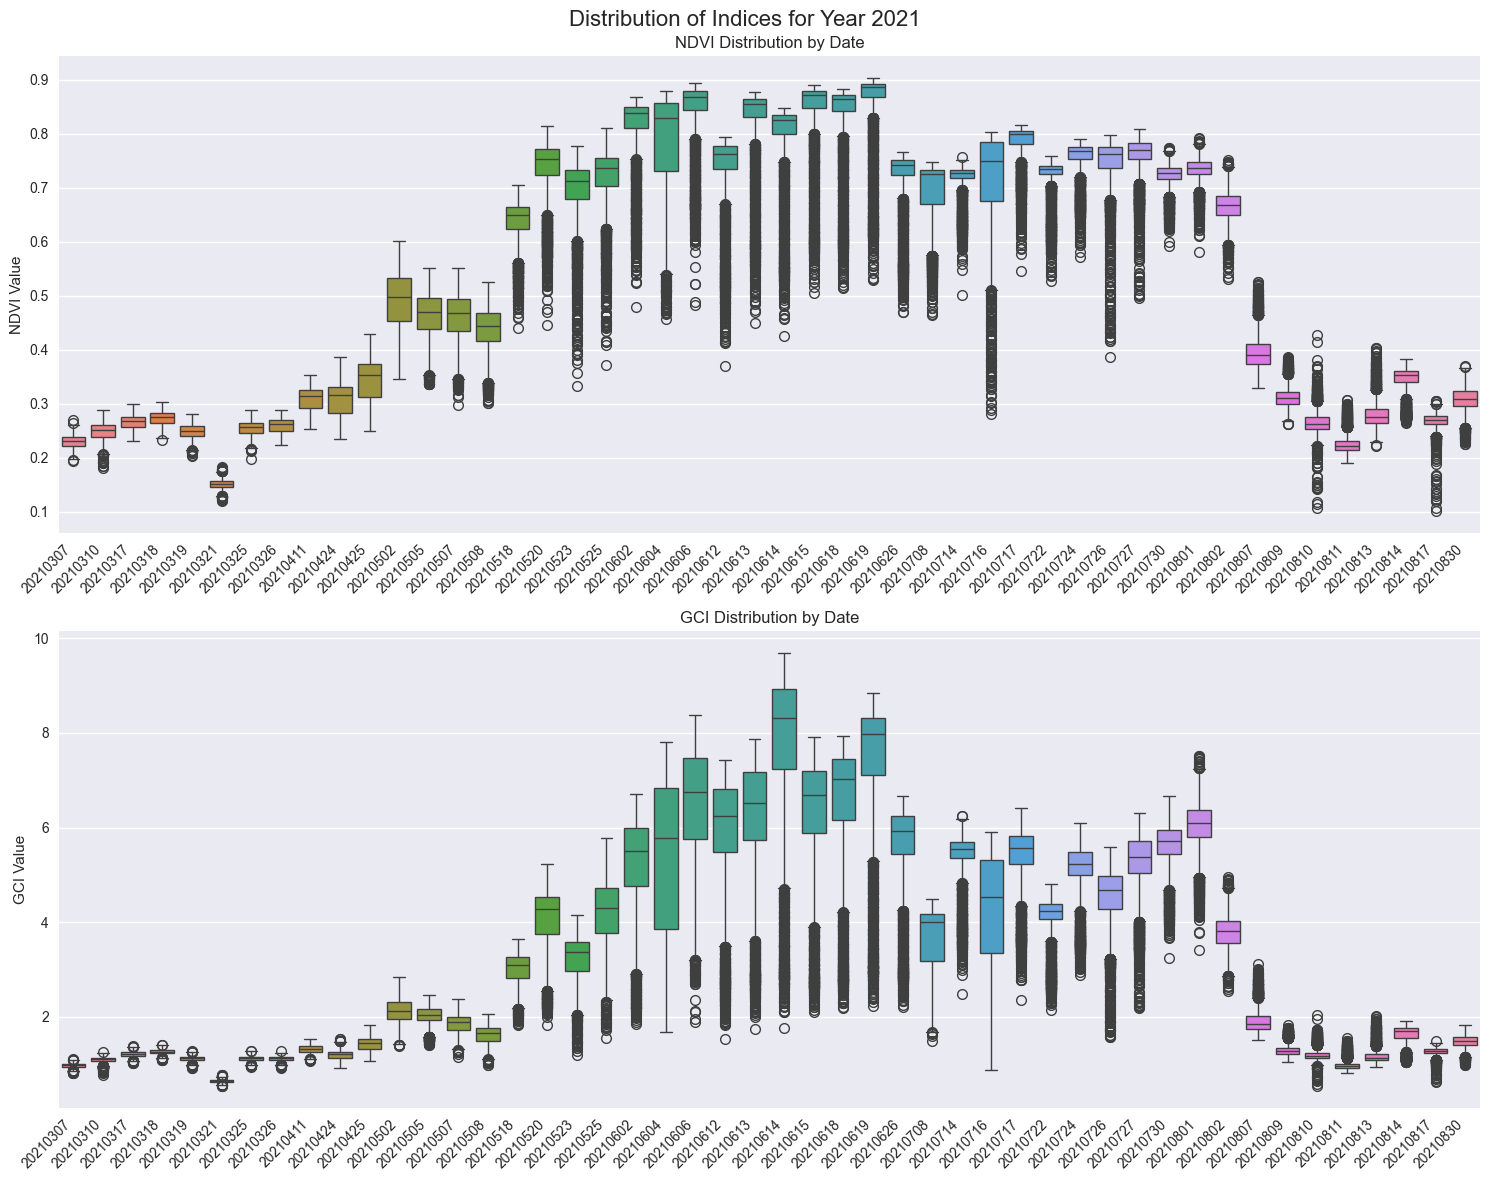

Processing year: 2022
Saved time series plot to: /Users/phani/Desktop/Crop_yield_data copy/Indices/plots/indices_2022.png


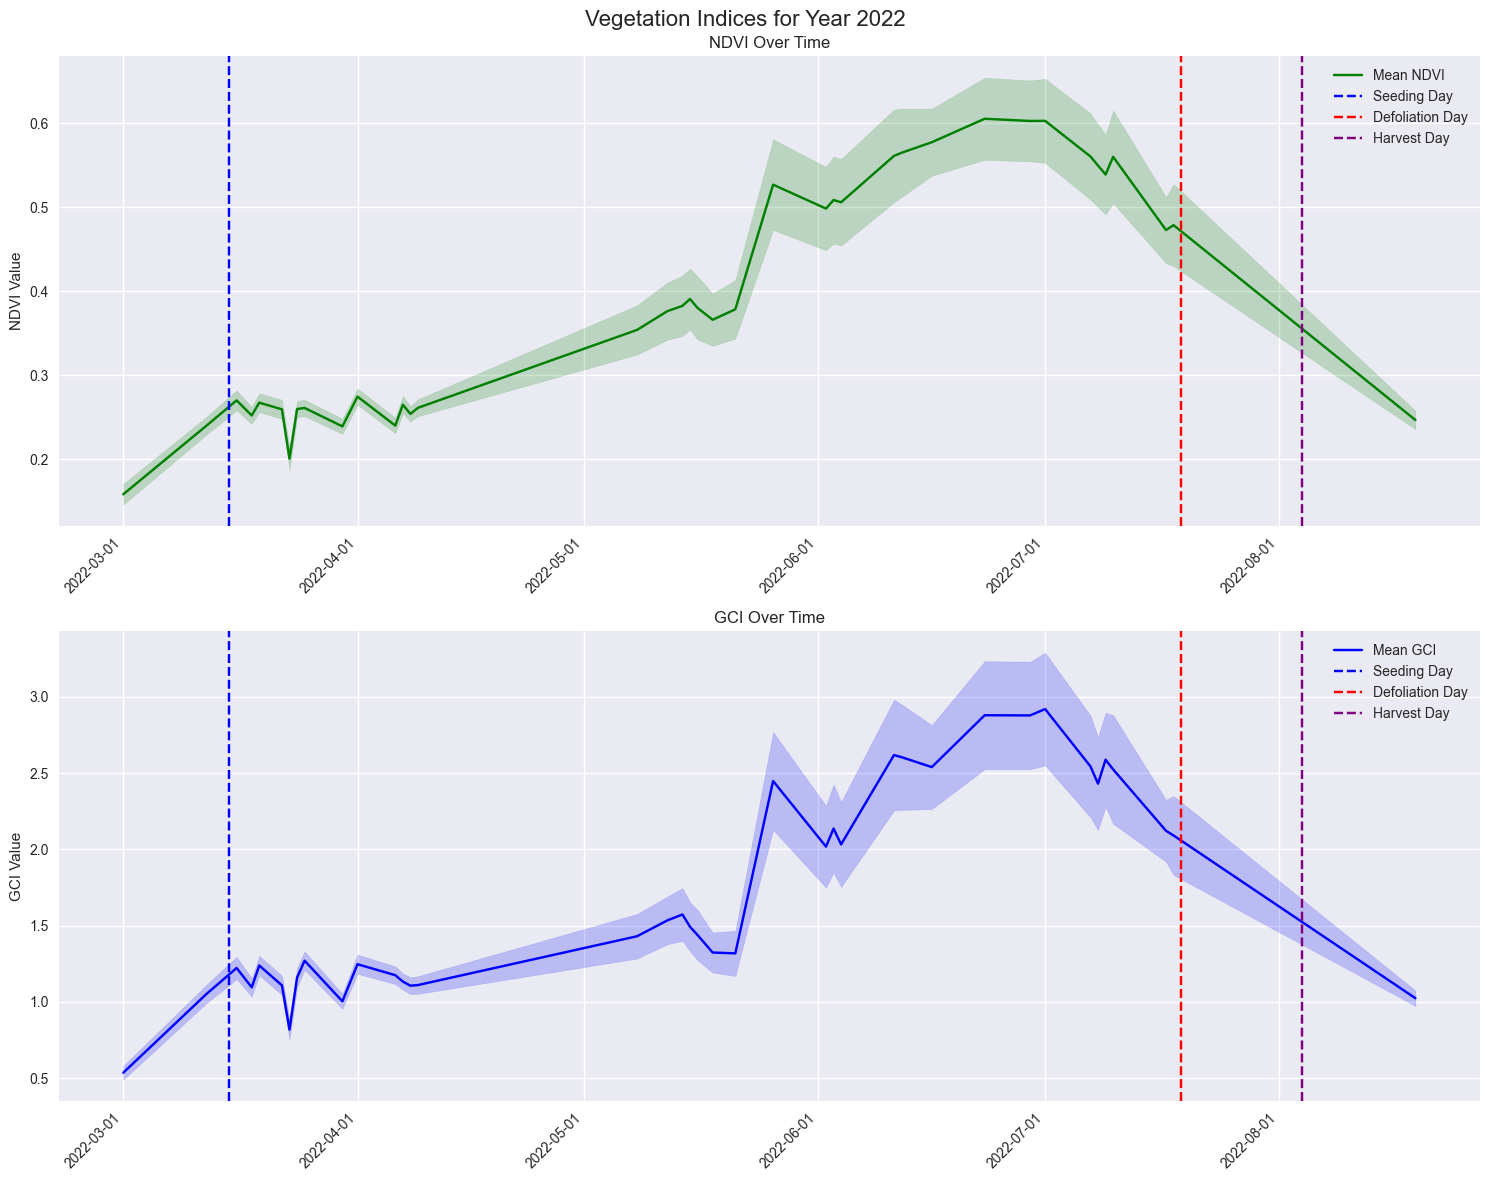

Saved boxplot to: /Users/phani/Desktop/Crop_yield_data copy/Indices/plots/indices_boxplot_2022.png


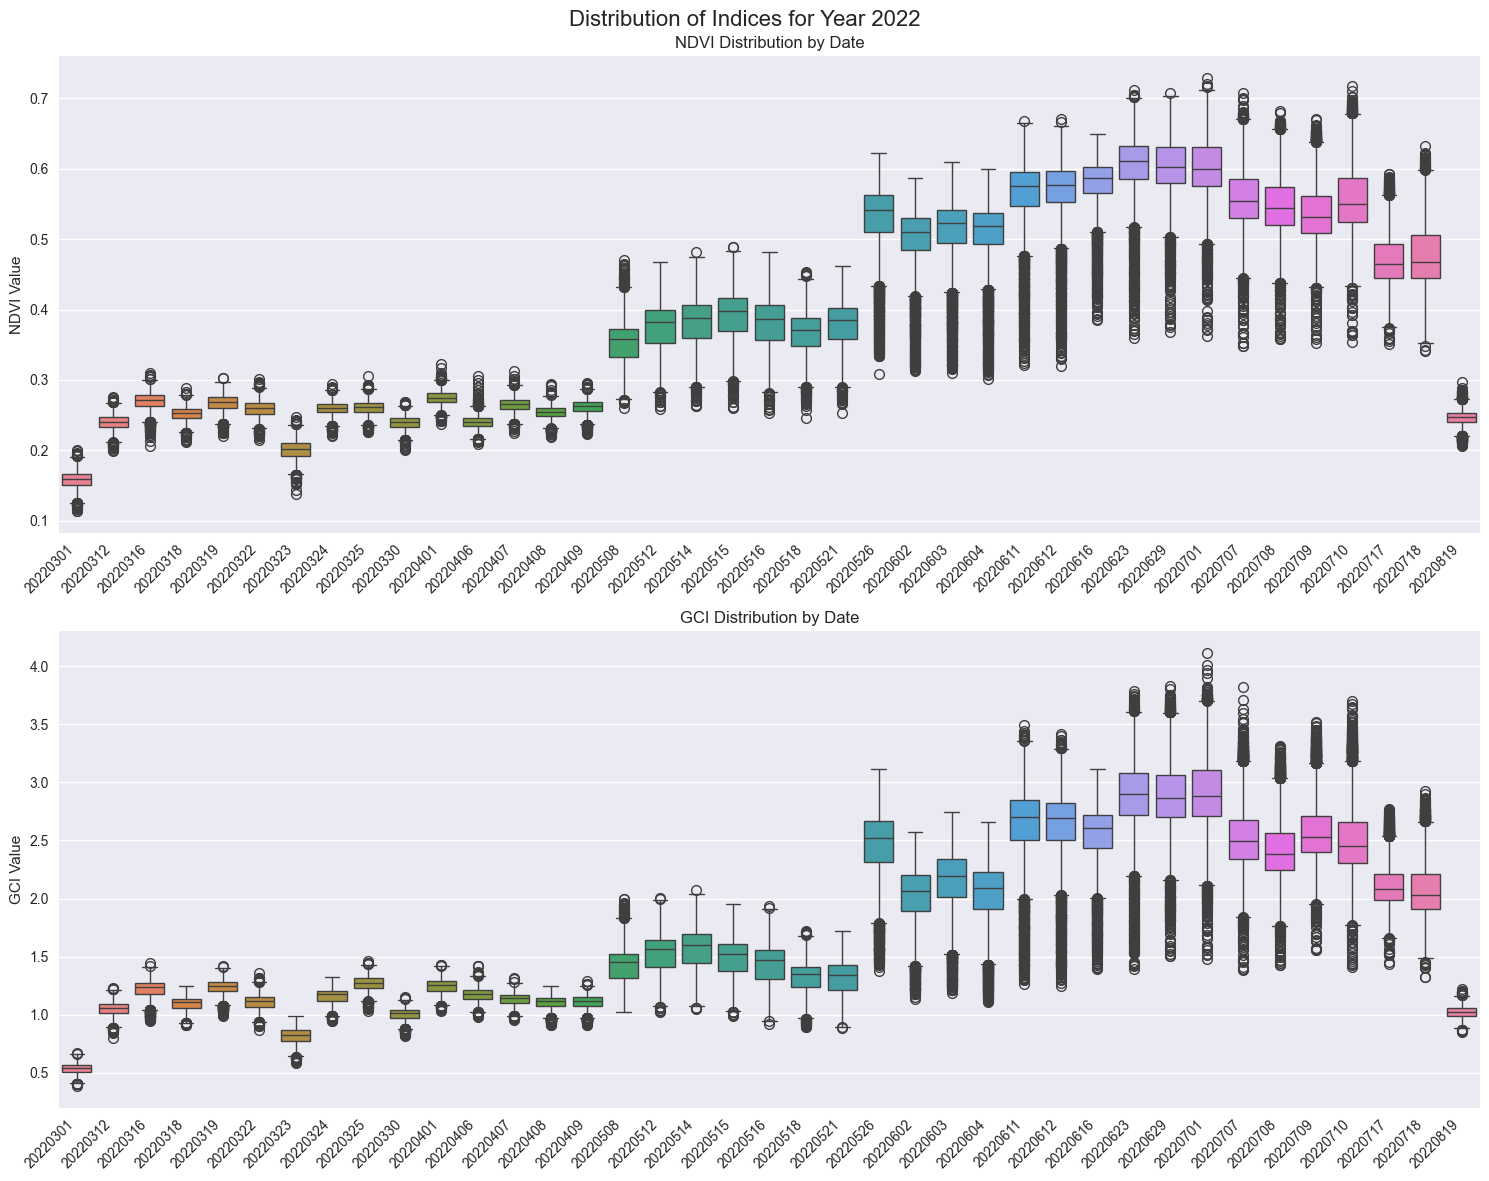

Processing year: 2023
Saved time series plot to: /Users/phani/Desktop/Crop_yield_data copy/Indices/plots/indices_2023.png


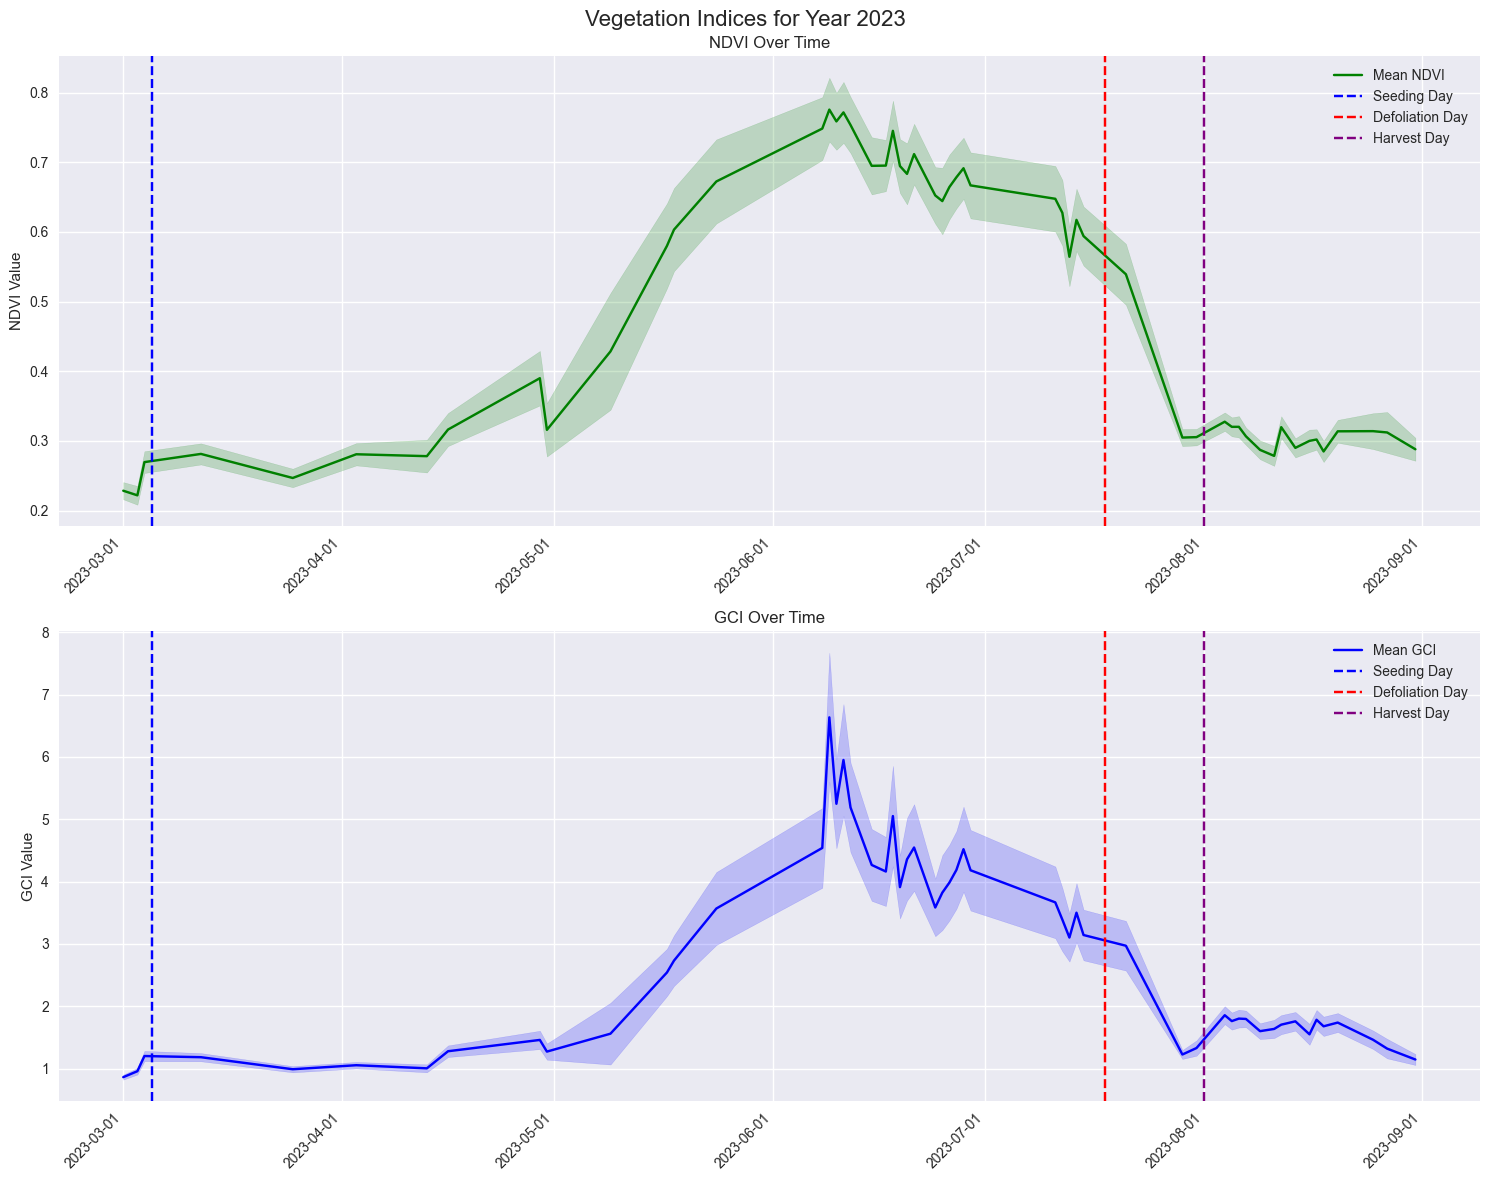

Saved boxplot to: /Users/phani/Desktop/Crop_yield_data copy/Indices/plots/indices_boxplot_2023.png


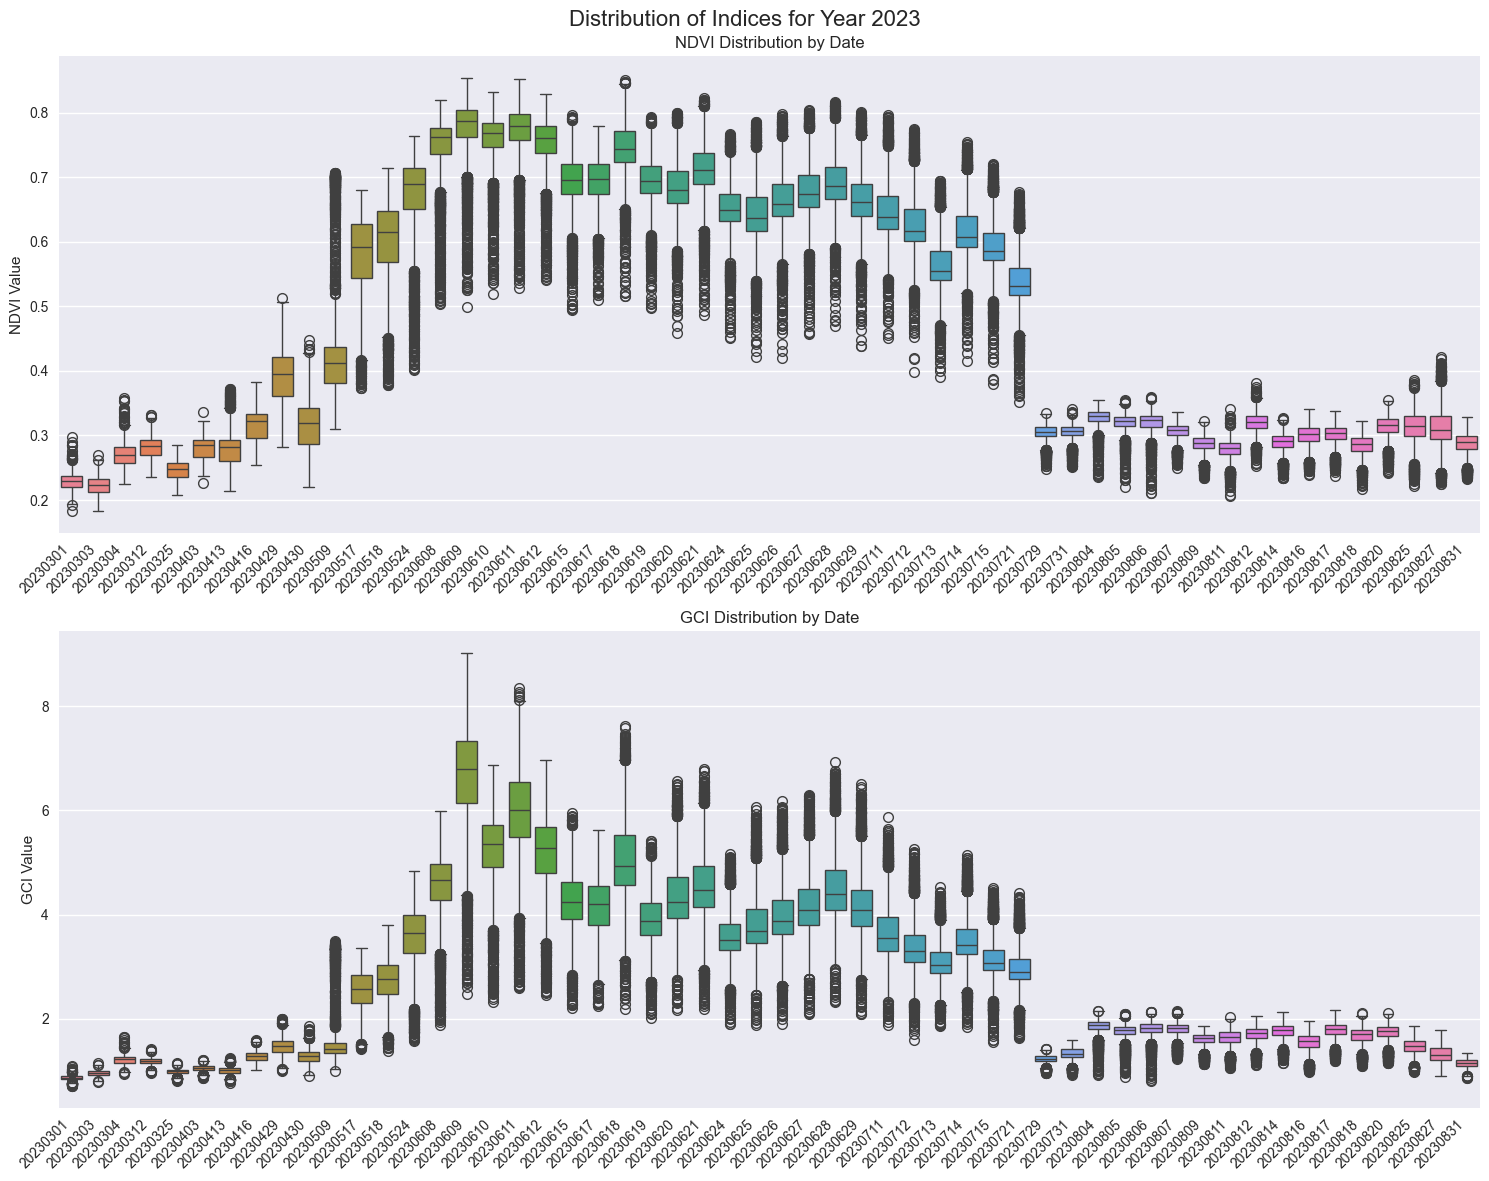

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os

def plot_yearly_indices(indices_dir, season_dates):
    """
    Create plots for NDVI and GCI values for each year
    """
    plt.style.use('seaborn-v0_8')
    
    ndvi_dir = os.path.join(indices_dir, 'NDVI')
    gci_dir = os.path.join(indices_dir, 'GCI')
    
    ndvi_files = sorted([f for f in os.listdir(ndvi_dir) if f.endswith('.csv')])
    
    for ndvi_file in ndvi_files:
        try:
            year = int(ndvi_file.split('_')[1].split('.')[0])
            print(f"Processing year: {year}")
            
            # Get season dates for this year
            year_dates = season_dates[season_dates['Year'] == year]
            if year_dates.empty:
                print(f"No season dates found for year {year}")
                continue
            
            # Read CSV files
            ndvi_df = pd.read_csv(os.path.join(ndvi_dir, ndvi_file))
            gci_df = pd.read_csv(os.path.join(gci_dir, f'GCI_{year}.csv'))
            
            # Create figure for time series
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
            fig.suptitle(f'Vegetation Indices for Year {year}', fontsize=16)
            
            # Plot NDVI
            ndvi_stats = ndvi_df.drop('FID', axis=1).agg(['mean', 'std']).T
            ndvi_stats.index = pd.to_datetime(ndvi_stats.index, format='%Y%m%d')
            ndvi_stats = ndvi_stats.sort_index()
            
            ax1.plot(ndvi_stats.index, ndvi_stats['mean'], 'g-', label='Mean NDVI')
            ax1.fill_between(ndvi_stats.index, 
                           ndvi_stats['mean'] - ndvi_stats['std'],
                           ndvi_stats['mean'] + ndvi_stats['std'],
                           alpha=0.2, color='green')
            
            # Add season markers to NDVI plot
            year_dates = year_dates.iloc[0]
            ax1.axvline(x=year_dates['Seeding_Day'], color='blue', linestyle='--', 
                       label='Seeding Day')
            ax1.axvline(x=year_dates['Defoliation_Day'], color='red', linestyle='--', 
                       label='Defoliation Day')
            ax1.axvline(x=year_dates['Harvest_Day'], color='purple', linestyle='--', 
                       label='Harvest Day')
            
            ax1.set_title('NDVI Over Time')
            ax1.set_ylabel('NDVI Value')
            ax1.grid(True)
            ax1.legend()
            
            # Format x-axis for NDVI plot
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            
            # Plot GCI
            gci_stats = gci_df.drop('FID', axis=1).agg(['mean', 'std']).T
            gci_stats.index = pd.to_datetime(gci_stats.index, format='%Y%m%d')
            gci_stats = gci_stats.sort_index()
            
            ax2.plot(gci_stats.index, gci_stats['mean'], 'b-', label='Mean GCI')
            ax2.fill_between(gci_stats.index,
                           gci_stats['mean'] - gci_stats['std'],
                           gci_stats['mean'] + gci_stats['std'],
                           alpha=0.2, color='blue')
            
            # Add season markers to GCI plot
            ax2.axvline(x=year_dates['Seeding_Day'], color='blue', linestyle='--', 
                       label='Seeding Day')
            ax2.axvline(x=year_dates['Defoliation_Day'], color='red', linestyle='--', 
                       label='Defoliation Day')
            ax2.axvline(x=year_dates['Harvest_Day'], color='purple', linestyle='--', 
                       label='Harvest Day')
            
            ax2.set_title('GCI Over Time')
            ax2.set_ylabel('GCI Value')
            ax2.grid(True)
            ax2.legend()
            
            # Format x-axis for GCI plot
            ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            
            # Rotate x-axis labels
            plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
            
            plt.tight_layout()
            
            # Save and display time series plot
            output_path = os.path.join(indices_dir, 'plots', f'indices_{year}.png')
            os.makedirs(os.path.join(indices_dir, 'plots'), exist_ok=True)
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            print(f"Saved time series plot to: {output_path}")
            plt.show()
            
            # Create boxplot visualization
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
            fig.suptitle(f'Distribution of Indices for Year {year}', fontsize=16)
            
            # NDVI boxplot
            sns.boxplot(data=ndvi_df.drop('FID', axis=1), ax=ax1)
            ax1.set_title('NDVI Distribution by Date')
            ax1.set_ylabel('NDVI Value')
            plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
            
            # GCI boxplot
            sns.boxplot(data=gci_df.drop('FID', axis=1), ax=ax2)
            ax2.set_title('GCI Distribution by Date')
            ax2.set_ylabel('GCI Value')
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
            
            plt.tight_layout()
            
            # Save and display boxplot
            output_path = os.path.join(indices_dir, 'plots', f'indices_boxplot_{year}.png')
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            print(f"Saved boxplot to: {output_path}")
            plt.show()
            
        except Exception as e:
            print(f"Error processing year {year}: {str(e)}")
            continue

# Create DataFrame for season dates
season_dates = pd.DataFrame({
    'Year': [2019, 2020, 2021, 2022, 2023],
    'Seeding_Day': pd.to_datetime(['2019-03-09', '2020-02-29', '2021-02-27', '2022-03-15', '2023-03-05']),
    'Defoliation_Day': pd.to_datetime(['2019-07-16', '2020-07-13', '2021-07-27', '2022-07-19', '2023-07-18']),
    'Harvest_Day': pd.to_datetime(['2019-07-29', '2020-08-03', '2021-08-13', '2022-08-04', '2023-08-01'])
})

# Example usage
indices_dir = "/Users/phani/Desktop/Crop_yield_data copy/Indices"
plot_yearly_indices(indices_dir, season_dates)

In [ ]:
# EXTRACT Features

In [111]:
import os
import rasterio
import geopandas as gpd
import numpy as np
import pandas as pd
from rasterio.mask import mask


def process_satellite_images(base_dir, top_shp_path, bottom_shp_path, output_base_dir):
    """
    Process all TIF files in yearly folders and create organized CSV outputs
    """
    # Create output directories
    ndvi_dir = os.path.join(output_base_dir, 'NDVI')
    gci_dir = os.path.join(output_base_dir, 'GCI')
    os.makedirs(ndvi_dir, exist_ok=True)
    os.makedirs(gci_dir, exist_ok=True)

    # Process each year directory
    for year_folder in sorted(os.listdir(base_dir)):
        year_path = os.path.join(base_dir, year_folder)

        # Skip if not a directory or not a year folder
        if not os.path.isdir(year_path) or not year_folder.isdigit():
            continue

        print(f"\nProcessing year: {year_folder}")

        try:
            # Select appropriate shapefile based on year
            year = int(year_folder)
            shapefile_path = bottom_shp_path if year % 2 == 0 else top_shp_path
            print(f"Using {'bottom' if year % 2 == 0 else 'top'} shapefile")

            shapefile = gpd.read_file(shapefile_path)

            # Initialize DataFrames for the year
            ndvi_df = pd.DataFrame({'FID': shapefile['FID']})
            gci_df = pd.DataFrame({'FID': shapefile['FID']})

            # Get all TIF files in the year folder
            tif_files = sorted([f for f in os.listdir(year_path) if f.endswith('.tif')])
            print(f"Found {len(tif_files)} TIF files")

            for tif_file in tif_files:
                try:
                    print(f"Processing: {tif_file}")
                    tif_path = os.path.join(year_path, tif_file)

                    # Calculate indices
                    ndvi_values, gci_values = calculate_indices(tif_path, shapefile)

                    # Use the file name (without extension) as column name
                    column_name = os.path.splitext(tif_file)[0]

                    # Add to DataFrames
                    ndvi_df[column_name] = pd.Series(ndvi_values)
                    gci_df[column_name] = pd.Series(gci_values)

                except Exception as e:
                    print(f"Error processing {tif_file}: {str(e)}")
                    continue

            # Save yearly results
            ndvi_output = os.path.join(ndvi_dir, f'NDVI_{year}.csv')
            gci_output = os.path.join(gci_dir, f'GCI_{year}.csv')

            ndvi_df.to_csv(ndvi_output, index=False)
            gci_df.to_csv(gci_output, index=False)

            print(f"Saved NDVI data to: {ndvi_output}")
            print(f"Saved GCI data to: {gci_output}")

        except Exception as e:
            print(f"Error processing year {year_folder}: {str(e)}")
            continue


def calculate_indices(raster_path, shapefile):
    """
    Calculate NDVI and GCI for the masked image
    """
    with rasterio.open(raster_path) as src:
        # Read bands (BGRNIR order)
        blue = src.read(1)
        green = src.read(2)
        red = src.read(3)
        nir = src.read(4)

        ndvi_values = {}
        gci_values = {}

        for idx, row in shapefile.iterrows():
            try:
                geometry = [row['geometry']]

                # Mask the image for current geometry
                masked_nir, _ = mask(src, geometry, crop=True, indexes=4)
                masked_red, _ = mask(src, geometry, crop=True, indexes=3)
                masked_green, _ = mask(src, geometry, crop=True, indexes=2)

                # Convert to float32
                masked_nir = masked_nir.astype(np.float32)
                masked_red = masked_red.astype(np.float32)
                masked_green = masked_green.astype(np.float32)

                # Create valid pixel masks
                valid_pixels = (masked_nir > 0) & (masked_red > 0) & (masked_green > 0)

                if np.any(valid_pixels):
                    # Calculate NDVI
                    ndvi = np.where(valid_pixels,
                                    (masked_nir - masked_red) / (masked_nir + masked_red),
                                    np.nan)

                    # Calculate GCI
                    gci = np.where(valid_pixels,
                                   (masked_nir / masked_green) - 1,
                                   np.nan)

                    # Store means
                    ndvi_values[row['FID']] = np.nanmean(ndvi)
                    gci_values[row['FID']] = np.nanmean(gci)
                else:
                    ndvi_values[row['FID']] = np.nan
                    gci_values[row['FID']] = np.nan

            except Exception as e:
                print(f"Error processing FID {row['FID']}: {e}")
                ndvi_values[row['FID']] = np.nan
                gci_values[row['FID']] = np.nan

    return ndvi_values, gci_values



if __name__ == "__main__":
    base_dir = "/Users/phani/Desktop/Crop_yield_data copy/Extra_data/imagesSR"
    top_shp_path = "/Users/phani/Desktop/Crop_yield_data copy/9x9 Grids/Top Field/2022_cc_driscoll_grid_9m_sorghum.shp"
    bottom_shp_path = "/Users/phani/Desktop/Crop_yield_data copy/9x9 Grids/Bottom Field /2022_cc_driscoll_grid_9m_cotton.shp"
    output_base_dir = "/Users/phani/Desktop/Crop_yield_data copy/Indices"

    process_satellite_images(base_dir, top_shp_path, bottom_shp_path, output_base_dir)